<a href="https://colab.research.google.com/github/edoardorossi1995/Tesi/blob/main/Average_Reward_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

Algoritmo Q-Learning (off policy)

Task non episodico (continuativo)

Framework: Average Reward

Approssimatore funzionale: Rete Neurale Convessa *(cfr. articoli)*

# Drive & Environment Setting


In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
from functions.compressor import compress

import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-05-02 12:31:38.057754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Import Anagrafica e CTA

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
CTA30_18 = [cta30_18_path]

df = pd.read_csv(CTA30_18[0])
df['VLV_RAF_FDBK_00'] = df['VLV_RAF_FDBK_00'] / 100
df['VLV_SUR_FDBK_00'] = df['VLV_SUR_FDBK_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)

pca_df = compress(df)

In [79]:
print("Anagrafica shape:",df_def.shape,"\nDataframe shape:", df.shape,"\nPca Dataframe shape:", pca_df.shape)

Anagrafica shape: (76, 2) 
Dataframe shape: (141811, 76) 
Pca Dataframe shape: (141811, 7)


In [80]:
df_def

pointColName                            pointName
0   AUTOMAN_SERR_CMD_00  Automatico Manuale Serrande Comando
1    AUTOMAN_VLV_CMD_00   Automatico Manuale Valvole Comando
2      AUTOMAN_M_CMD_00   Automatico Manuale Mandata Comando
3      AUTOMAN_R_CMD_00   Automatico Manuale Ripresa Comando
4         LOCREM_CMD_00      Selettore Locale Remoto Comando
..                  ...                                  ...
71            VOLT_R_00                     Tensione Ripresa
72            T_M_SP_00    Temperatura Aria Mandata Setpoint
73            T_R_SP_00    Temperatura Aria Ritorno Setpoint
74             T_AMB_04      Temperatura Aria Ambiente Media
75        AUTOMAN_ST_00             Automatico Manuale Stato

[76 rows x 2 columns]

#### Supporto per velocizzare il parse di tutti i df

In [ ]:
nomi_colonne = df.columns
nomi = df.to_dict('list')
store_data(nomi, "nomi_colonne.pkl")

## Action Plots

<function matplotlib.pyplot.show(close=None, block=None)>

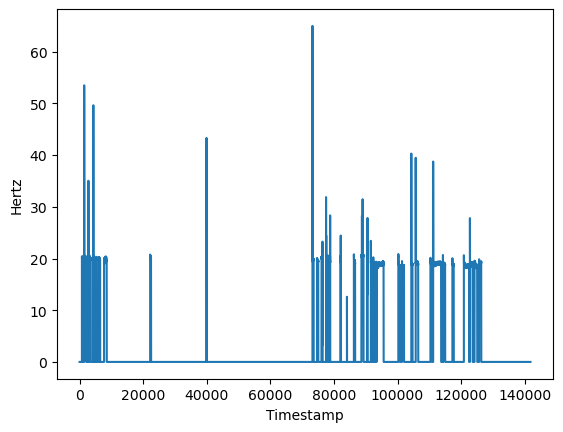

In [3]:
df_pw = df['PW_ATT_M_00']
plt.plot(df_pw)
plt.xlabel('Timestamp')
plt.ylabel('Hertz')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

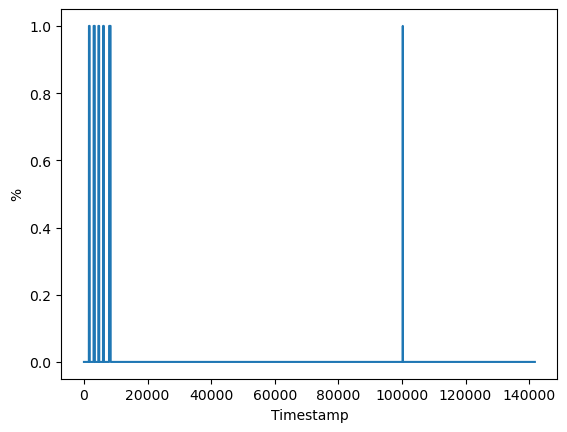

In [4]:
df_rf = df['VLV_RAF_FDBK_00']
plt.plot(df_rf)
plt.xlabel('Timestamp')
plt.ylabel('%')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

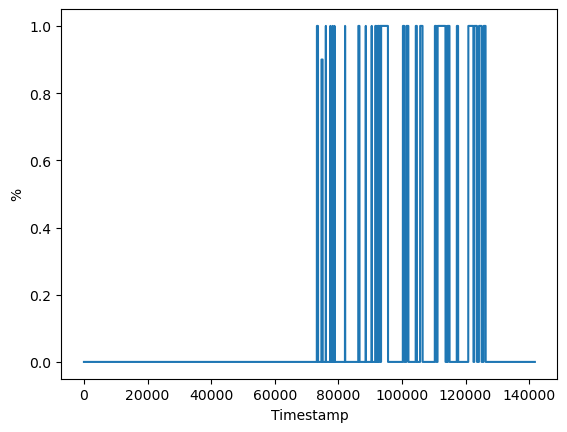

In [5]:
df_sr = df['VLV_SUR_FDBK_00']
plt.plot(df_sr)
plt.xlabel('Timestamp')
plt.ylabel('%')
plt.show

# Rete Neurale


## Custom Acts

Efficient reinforcement learning via difference of
log-sum-exp neural networks

*(Sven Brüggemann, Corrado Possieri)*

Esempio di funzione di attivazione personalizzata tramite estensione della classe Layer:

il metodo build() è responsabile dell'instansiazione dei pesi;

il metodo call() è la funzione di attivazione vera e propria.

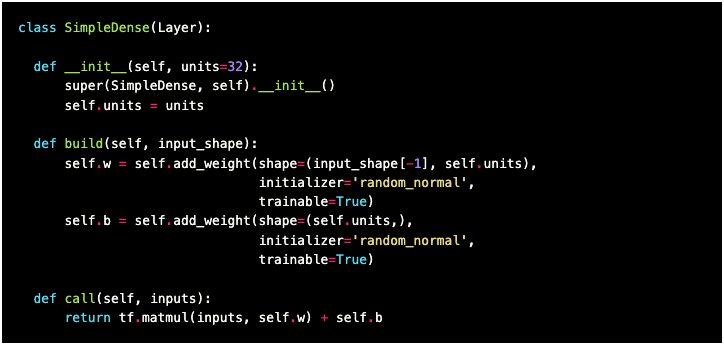

In [3]:
class ExpAct(Layer):
  def __init__(self, units, **kwargs):
    super(ExpAct, self).__init__()
    self.units = units
    self.T = 0.1

  def build(self, input_shape):
    self.a = self.add_weight(name="a", 
                             shape=(input_shape[-1], self.units),
                             initializer="glorot_normal", 
                             trainable=True)
    self.b = self.add_weight(name="b", 
                             shape=(self.units,),
                             initializer="zeros", 
                             trainable=True)
    super(ExpAct, self).build(input_shape)

  def call(self, x):
    z = x # notazione
    PSI = self.psi(z, self.a, self.b)
    aTz = K.dot(z,self.a)
    aTzb = (aTz+K.transpose(self.b)) / self.T
    output = aTzb - PSI
    exp_output = K.exp(output)
    #tf.print("z:",z)
    #tf.print("aTzb:",aTzb)
    #tf.print("psi exp:",PSI)
    #tf.print("output pre exp:", output)
    #tf.print("output post exp:", exp_output)
    return exp_output

  def psi(self, x, a, b):
    z = x # notazione
    a = self.a
    b = self.b
    ret = (K.dot(z, a) + K.transpose(b)) / self.T
    psi = tf.reduce_max(ret)

    return psi

class CustomOutput(Layer):
    def __init__(self, units, **kwargs):
        super(CustomOutput, self).__init__(**kwargs)
        self.units = units
        self.T = 0.1
    
    def build(self, input_shape):
        self.a = self.add_weight(name="a", 
                                 shape=(input_shape[-1], self.units),
                                 initializer="glorot_normal", 
                                 trainable=True)
        self.b = self.add_weight(name="b", 
                                 shape=(self.units,),
                                 initializer="zeros", 
                                 trainable=True)
        super(CustomOutput, self).build(input_shape)
    
    def call(self, x):
        z = x # notazione
        PSI = self.psi(z, self.a, self.b)
        output = self.T*(K.log(z)+PSI) 
        output = K.expand_dims(output[:,0], axis=-1)
        #tf.print("log output:", output)
        return output

    def psi(self, x, a, b):
        z = x # notazione
        a = self.a
        b = self.b
        ret = K.dot(z, a) + K.transpose(b)
        psi = tf.reduce_max(ret, axis=0, keepdims=True)
        psi_max = K.max(psi) 
        return tf.reshape(psi_max, (1,))
    
    
#class LogAct(Layer):
#  def __init__(self, input_dim, units, **kwargs):
#    super(LogAct, self).__init__(**kwargs)
#    self.input_dim = input_dim
#    self.units = units
#    self.T = 0.1
#    
#  def build(self, input_shape):
#    self.a = self.add_weight(name="a", 
#                             shape=(input_shape[-1], self.units),
#                             initializer="glorot_normal", 
#                             trainable=True)
#    self.b = self.add_weight(name="b", 
#                             shape=(self.units,),
#                             initializer="zeros", 
#                             trainable=True)
#    super(LogAct, self).build(input_shape)
#
#  def call(self, x):
#    z = x / self.T
#    PSI = self.psi(z, self.a, self.b)
#    output = self.T * (PSI + K.log(z))
#    print("output dim: ", output.shape)
#    return output
#
#  def psi(self, x, a, b):
#    z = x / self.T
#    a = self.a
#    b = self.b
#    ret = (K.dot(z, self.a) + K.transpose(self.b)) / self.T
#    psi = tf.reduce_max(ret)
#    print("log psi: ", psi.shape)
#    #psi_value = K.eval(psi)[0]
#    #print("log psi: ", psi_value)
#    return psi

## NN Creation

Log-sum-exp neural networks and posynomial
models for convex and log-log-convex data 

*(Calafiore, Gaubert, Possieri)*

In [29]:
n = load_data('_.pkl')
if IN_COLAB == True:
    n = load_data('*.pkl')

action_vector_dimension = 2

# Architettura rete neurale
input_dim = n['n_components'] + action_vector_dimension
inner_dim_1 = 32
output_dim = 1

print("input dim: ", input_dim)
print("inner layer dim: ", inner_dim_1)
print("output dim: ", output_dim)

# Definizione dei layer
exp_act_layer = ExpAct(units=inner_dim_1)
log_act_layer = CustomOutput(units=output_dim)

# Costruzione del modello
input_layer = Input(shape=(input_dim,))
hidden_layer = exp_act_layer(input_layer)
output_layer = log_act_layer(hidden_layer)

# Definizione del modello
rete_neurale = Model(inputs=input_layer, outputs=output_layer)

# Impostazione learning rate
lr = 0.01
adam_opt = Adam(lr = lr)

# Compilazione del modello
rete_neurale.compile(optimizer=adam_opt, loss='mean_squared_error', metrics=['mae'])

# print("weights: ",rete_neurale.get_weights())
rete_neurale.summary()

# Definisco funzione obiettivo per la massimizzazione della predizione 
def objective(x):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(7,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

input dim:  9
inner layer dim:  32
output dim:  1
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9)]               0         
                                                                 
 exp_act_3 (ExpAct)          (None, 32)                320       
                                                                 
 custom_output_3 (CustomOutp  (None, 1)                33        
 ut)                                                             
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [30]:
print("weights: ",rete_neurale.get_weights())
# Generazione di un input_data casuale di dimensione (batch_size, input_dim)

batch_size = 1
input_dim = n['n_components'] + action_vector_dimension
input_data = np.concatenate([np.random.rand(batch_size, 7), np.array([[0.00145645, 0.9979683]] * batch_size)], axis=1)
output = rete_neurale.predict(input_data)
print("prediction:",output)

www = rete_neurale.get_weights()
a = www[0]
b = www[1]
target = np.array([-2.411904998123646])
rete_neurale.fit(input_data, target, epochs=1, verbose=0)
print("weights: ",rete_neurale.get_weights())



weights:  [array([[-7.85506889e-02, -3.23078752e-01,  1.68955140e-02,
         3.89063172e-02,  8.73557404e-02,  2.91266292e-01,
         2.87407160e-01, -4.15448174e-02,  2.34909251e-01,
        -4.29259464e-02, -4.18943852e-01,  2.06642240e-01,
        -4.47838902e-02,  5.48911514e-03, -2.46488944e-01,
         8.07080120e-02,  1.75026447e-01,  1.51059851e-01,
         4.81206834e-01,  2.07922131e-01, -2.97023654e-01,
         2.46959195e-01,  2.90985048e-01,  1.39894471e-01,
        -1.67147323e-01,  8.42148960e-02, -5.12023680e-02,
         1.02728799e-01, -8.87436271e-02,  4.38089296e-02,
        -7.08939414e-03,  7.95398876e-02],
       [ 2.31436089e-01, -1.56274304e-01, -1.73766688e-01,
         2.10527062e-01, -7.42238685e-02, -2.43309602e-01,
        -9.19772610e-02, -2.16520187e-02,  2.82883406e-01,
        -2.79638708e-01,  1.80409290e-02,  9.33408067e-02,
        -4.98492986e-01,  6.62479550e-02, -7.63426349e-02,
         3.88496444e-02, -1.19666442e-01,  9.70768929e-02,
  

# Q-Learning Agent

## Learning Setting

In [31]:
# Dimensione problema e inizializzazione stato iniziale
[S, feat] = df.shape
current_state = 0 # np.random.randint(0,S-1)

# Stato corrente
s = current_state

min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = df['VLV_RAF_FDBK_00'] * 0.5
a_sur_df = df['VLV_SUR_FDBK_00'] * 0.5 + 0.5000000001

# Parametri di apprendimento (discount factor, average rate)
gamma = 1
beta = 0.75

# Media mobile esponenziale (avr = avr + beta * (r - avr)) 
# [scelta perché computazionalmente più leggera di una media aritmetica]
average_reward = -np.random.randint(np.min(df.loc[:,'PW_ATT_M_00']),np.max(df.loc[:,'PW_ATT_M_00']))
print("average_reward start: ", average_reward,"\n")

pca_df.loc[5000,:].values.reshape(7,1)

average_reward start:  -36 



array([[ 7.64928491e-02],
       [ 1.94226244e+00],
       [-5.89399386e-01],
       [ 1.44398258e+00],
       [ 5.21855103e-01],
       [ 3.34505117e-01],
       [-1.35189727e-03]])

## Training

In [32]:
# N.B. Per mantenere 2 azioni ma implementare l'alternanza caldo freddo sulle valvole
# bisogna mappare le azioni in questo modo:
# [0 / 50) -> freddo
# [50 / 100] -> caldo


# Setting Episodi
total_episodes = 50
current_episode = 5000

# Ripeti finché non raggiungi la fine del processo
for current_episode in range(total_episodes):
    
    # Stato successivo e ottieni l'azione A e la ricompensa R
    s_prime = s+1
    if s_prime > S-1:
      print("s =", s)
      break
    # a1 = frequenza sul motore di mandata
    a1 = df.loc[s,'F_M_FDBK_00']

    # a2 = percentuale di apertura delle valvole caldo/freddo (esclusive)
    a_raf = df.loc[s,'VLV_RAF_FDBK_00']
    a_sur = df.loc[s,'VLV_SUR_FDBK_00']
    if a_raf == 0:
      if a_sur == 0:
        a2 = 0
      else:
        a2 = a_sur_df[s]
    else:
      a2 = a_raf_df[s]
       
    a = (a1,a2)

    # r = - potenza attiva (da massimizzare)
    r = -df.loc[s,'PW_ATT_M_00']
    average_reward = (1 - beta) * average_reward + beta * (r)

    # Condizioni iniziali (random) della minimizzazione della funzione obiettivo 
    # per la predizione di q'
    data_f = a_f_m_scaled
    a0_f = data_f[np.random.randint(len(data_f))]
    a0_v = np.random.rand()
    x0 = [a0_f, a0_v]

    # Dominio della minimizzazione 
    bounds = [(min_f, max_f), (0,1)]
    print("minimizing...")
    start_time = time.time()
    # Risultato della minimizzazione
    #objective_minimized = minimize(objective, x0, method='BFGS', bounds=bounds)
    objective_minimized = differential_evolution(objective, bounds=bounds)
    end_time = time.time()
    print("time elapsed: ", end_time - start_time, "seconds")
    print("minimized")
    print("predicting...")
    # Compongo input della predizione di q'
    #a1_prime_input = np.array([objective_minimized.x[0]])#.reshape(1,1)
    a1_prime_input = np.array([objective_minimized.x[0]]).reshape(1,1)
    a2_prime_input = objective_minimized.x[1].reshape(1,1)
    #a2_prime_input = np.array([objective_minimized.x[1]])
    s_prime_input = pca_df.loc[s_prime,:].values.reshape(7,1)
    conc1 = np.concatenate((s_prime_input, a1_prime_input), axis=0)
    a2_prime_input = np.expand_dims(a2_prime_input, axis=1).reshape(1,1)
    conc2 = np.concatenate((conc1, a2_prime_input), axis=0)
    nn_input_prime = np.reshape(conc2, (1,input_dim))
    #nn_input_prime = np.concatenate((s_prime_input, np.squeeze(a1_prime_input), a2_prime_input),axis = 0)
    #nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))

    # Predizione di q'
    q_prime = rete_neurale.predict(nn_input_prime, verbose = 0)[0]
    print("q' predicted:", q_prime)
    q_prime = q_prime[0]
    # Calcola la media delle ricompense future attese per lo stato-azione corrente
    # q = avr + gamma*max(q')
    q = (average_reward + gamma * (q_prime))
    print("q: ", q)
    # Calcola il valore target per il training della rete neurale
    target = q
    target = np.array([target])

    # Aggiorna la rete neurale
    pca_s = pca_df.loc[s,:]
    nn_input = np.concatenate((pca_s.values, np.array([a[0],a[1]])))
    nn_input = np.reshape(nn_input, (1,input_dim))    
    print("weights pre fit: ", rete_neurale.get_weights())
    rete_neurale.fit(nn_input, target, epochs=1, verbose=0)
    print("weights post fit: ", rete_neurale.get_weights())
    # Aggiorna lo stato corrente
    s = s_prime

    # Plot statistiche ogni 100 episodi    
    n_print = 20
    if current_episode%n_print == 0:
      print("current_episode = ", current_episode)
      print("Episodio ",current_episode,"/",total_episodes)
      print("reward: ",r,"\naverage_reward: ",average_reward)
      print("\n")


    n_save = 5
    #if current_episode%n_save == 0:
      # Salva la rete neurale
      #rete_neurale.save('rete_neurale.h5')


minimizing...
time elapsed:  60.652158975601196 seconds
minimized
predicting...
q' predicted: [-0.65848106]
q:  -9.658481061458588
weights pre fit:  [array([[-0.08855067, -0.3131885 ,  0.02688635,  0.02934631,  0.09735502,
         0.28128606,  0.2774073 , -0.05144318,  0.24490893, -0.04296714,
        -0.41007674,  0.21659954, -0.05469023,  0.01548383, -0.25642166,
         0.090708  ,  0.18370195,  0.16105883,  0.4911715 ,  0.21791916,
        -0.30697542,  0.23713444,  0.3009393 ,  0.12989523, -0.15716378,
         0.07424627, -0.06107625,  0.09273861, -0.08226413,  0.03380913,
         0.00170656,  0.06954039],
       [ 0.2214361 , -0.14635795, -0.16377366,  0.20086513, -0.06422441,
        -0.2532946 , -0.10197717, -0.03157456,  0.29288316, -0.27969283,
         0.02715562,  0.10330831, -0.5084216 ,  0.07624394, -0.0862914 ,
         0.04884963, -0.11070641,  0.10707611, -0.03224721,  0.3572695 ,
        -0.26364872,  0.39727607, -0.01204646,  0.25061134,  0.19873576,
         0.2

KeyboardInterrupt: 